In [0]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Loading Data  file in Google Drive**

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

# Downloading a file based on its file ID
downloaded = drive.CreateFile({'id':'12rJAV6wO5I47FwxNHUUJLgrr7-LLPOsL'}) 
downloaded.GetContentFile('database.sqlite')



In [0]:
con = sqlite3.connect('database.sqlite')

In [156]:
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""" , con)
# Getting data into a dataframe
#filtered_data = pd.read_csv('Reviews.csv')
def partition(x):
    if x>3:
        return 1 
    else:
        return 0
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
filtered_data.shape
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [158]:
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep = 'first' ,inplace=False)
final.shape

(364173, 10)

In [159]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [160]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

**Text Preprocessing**

In [161]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from tqdm import tqdm
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext
#define function to clean the word of punctuation or special character
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
    

In [163]:
from nltk.stem import PorterStemmer
sno = nltk.stem.SnowballStemmer('english')
sno.stem('tasty')

'tasti'

In [0]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
import re
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
    
    

In [165]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [0]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']


In [167]:
# Finding all words in the vocabulary
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
count_vect.fit(x)

vocabulary = count_vect.get_feature_names()
print('No. of words in the Vocabulary : ',len(vocabulary))

No. of words in the Vocabulary :  98496


In [0]:
# Storing all words in the dictionary (words as keys and index as values)
Dictionary = dict()
ind = 0
for sent in x:
  for word in sent.split():
    Dictionary.setdefault(word,[])
    Dictionary[word].append(ind)
    ind += 1

In [0]:
# Getting frequency for each word of vocabulary and storing it in a list
freq = []
for w in vocabulary:
  freq.append(len(Dictionary[w]))

In [0]:
# Getting Index for each word in the vocabulary
inc_index =np.argsort(np.array(freq))[::-1]


In [0]:
# Allocating ranks to words of vocabulary in decreasing order of frequency and storing words in a dictionary
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [0]:
# Converting full data into imdb format
data = []
for sent in x:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [0]:
# Splitting the data into 50-50 train_data and test_data
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.5, random_state=42)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

In [175]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(182085, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    5   14  385 3432   61
    9 1245  290  938  343   81  998   96  530   90   49   13  953 1251
  812  601]


In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

**(1) RNN with 1 LSTM layer**

In [177]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 32)           3151872   
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 3,205,173
Trainable params: 3,205,173
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
# Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 182085 samples, validate on 182086 samples
Epoch 1/10
182085/182085 [==============================] - 103s 567us/step - loss: 0.2638 - acc: 0.8979 - val_loss: 0.2029 - val_acc: 0.9216
Epoch 2/10
182085/182085 [==============================] - 102s 559us/step - loss: 0.1817 - acc: 0.9304 - val_loss: 0.1987 - val_acc: 0.9216
Epoch 3/10
182085/182085 [==============================] - 103s 563us/step - loss: 0.1644 - acc: 0.9371 - val_loss: 0.1986 - val_acc: 0.9215
Epoch 4/10
182085/182085 [==============================] - 103s 567us/step - loss: 0.1526 - acc: 0.9416 - val_loss: 0.2079 - val_acc: 0.9200
Epoch 5/10
182085/182085 [==============================] - 104s 572us/step - loss: 0.1413 - acc: 0.9463 - val_loss: 0.2029 - val_acc: 0.9206
Epoch 6/10
182085/182085 [==============================] - 103s 567us/step - loss: 0.1301 - acc: 0.9510 - val_loss: 0.2126 - val_acc: 0.9207
Epoch 7/10
182085/182085 [==============================] - 103s 563us/step - loss: 0.1179 - acc

Test loss: 0.26529355157468715
Test accuracy: 0.9150730973276364


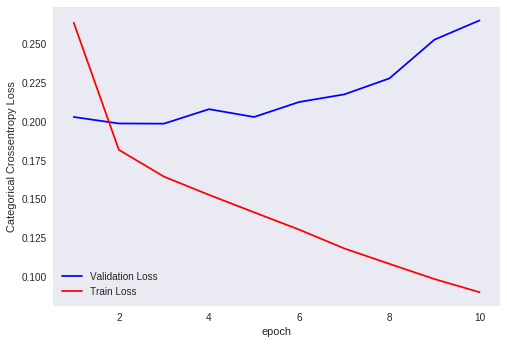

In [180]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
epochs = 10

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

**(2) RNN with 2 LSTM layer**

In [185]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))
# Adding first LSTM layer
model.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 32)           3151872   
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 100)          53200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 3,285,573
Trainable params: 3,285,573
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [187]:
# Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 182085 samples, validate on 182086 samples
Epoch 1/10
182085/182085 [==============================] - 226s 1ms/step - loss: 0.2745 - acc: 0.8943 - val_loss: 0.2053 - val_acc: 0.9204
Epoch 2/10
182085/182085 [==============================] - 224s 1ms/step - loss: 0.1935 - acc: 0.9250 - val_loss: 0.1981 - val_acc: 0.9217
Epoch 3/10
182085/182085 [==============================] - 224s 1ms/step - loss: 0.1770 - acc: 0.9323 - val_loss: 0.2011 - val_acc: 0.9225
Epoch 4/10
182085/182085 [==============================] - 225s 1ms/step - loss: 0.1667 - acc: 0.9363 - val_loss: 0.1987 - val_acc: 0.9236
Epoch 5/10
182085/182085 [==============================] - 224s 1ms/step - loss: 0.1574 - acc: 0.9399 - val_loss: 0.2026 - val_acc: 0.9226
Epoch 6/10
182085/182085 [==============================] - 224s 1ms/step - loss: 0.1503 - acc: 0.9429 - val_loss: 0.2020 - val_acc: 0.9221
Epoch 7/10
182085/182085 [==============================] - 223s 1ms/step - loss: 0.1444 - acc: 0.9452 - val

Test loss: 0.21942285291394065
Test accuracy: 0.920268444581132


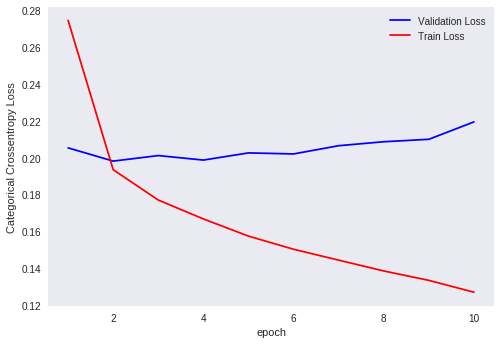

In [189]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

**Conclusion:**

In [190]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["MOdel","Test AUC","Test Loss"]

x.add_row([" RNN with 1 LSTM layer","91.5%","0.26529355157468715"])
x.add_row(["RNN with 2 LSTM layer","92%","0.21942285291394065"])



print(x)

+------------------------+----------+---------------------+
|         MOdel          | Test AUC |      Test Loss      |
+------------------------+----------+---------------------+
|  RNN with 1 LSTM layer |  91.5%   | 0.26529355157468715 |
| RNN with 2 LSTM layer  |   92%    | 0.21942285291394065 |
+------------------------+----------+---------------------+


1) As number of layers increases accuracy increases. 2) As number of layers increases loss decreases.3) By observing error plots, in both plots as number of epoch increases model is overfitting. 4) As number of layer increases computation time increases.​

